# Read SAS Files
The following data can be found here:
https://wwwn.cdc.gov/nchs/nhanes/

In [1]:
# Read SAS file
import pandas as pd

In [2]:
# NHANES 2017-2018 vaccination Immunization
nhanes1314_Vaccination = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/IMQ_H.XPT", format = "xport")

In [3]:
# NHANES 2017-2018 core antibody surface antigen
nhanes1314_BG = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HEPBD_H.XPT", format = "xport" )

In [4]:
# NHANES 2017-2018 surface antibody
nhanes1314_Antibody = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HEPB_S_H.XPT", format = "xport")

In [5]:
nhanes1314_Vaccination = nhanes1314_Vaccination[['SEQN','IMQ020']]

In [6]:
nhanes1314_BG = nhanes1314_BG[['SEQN','LBXHBC','LBDHBG']]

In [7]:
nhanes1314_Antibody

,SEQN,LBXHBS
0,73557.0,1.0
1,73558.0,2.0
2,73559.0,2.0
3,73560.0,2.0
4,73561.0,2.0
...,...,...
9170,83727.0,2.0
9171,83728.0,1.0
9172,83729.0,2.0
9173,83730.0,2.0


In [8]:
nhanes1314_No_vaccination = nhanes1314_Vaccination[(nhanes1314_Vaccination['IMQ020']==3.0) | (nhanes1314_Vaccination['IMQ020']==7.0) | (nhanes1314_Vaccination['IMQ020']==9.0)]

In [9]:
nhanes1314_No_vaccination

,SEQN,IMQ020
0,73557.0,3.0
1,73558.0,3.0
2,73559.0,3.0
4,73561.0,3.0
5,73562.0,9.0
...,...,...
10160,83717.0,3.0
10161,83718.0,9.0
10167,83724.0,3.0
10169,83726.0,3.0


In [10]:
nhanes1314_club_1 = pd.merge(nhanes1314_No_vaccination, nhanes1314_Antibody, on="SEQN", how = "left")

In [11]:
nhanes1314_club_2 = pd.merge(nhanes1314_club_1, nhanes1314_BG, on="SEQN", how = "left")

In [12]:
import pandas as pd
import pandas.io.sql as sqlio

In [13]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [14]:
from pandasql import sqldf

In [15]:
query = '''
SELECT SEQN, (CASE WHEN LBXHBC = 1.0 THEN 'Positive' WHEN LBXHBC = 2.0 THEN 'Negative' WHEN LBXHBC IS NULL THEN 'Missing' END) AS Core_Antibody,
(CASE WHEN LBDHBG = 1.0 THEN 'Positive' WHEN LBDHBG = 2.0 THEN 'Negative' WHEN LBDHBG IS NULL THEN 'Missing' END) AS Surface_Antigen,
(CASE WHEN LBXHBS = 1.0 THEN 'Positive' WHEN LBXHBS = 2.0 THEN 'Negative' WHEN LBXHBS IS NULL THEN 'Missing' END) AS Surface_Antibody,
(CASE WHEN IMQ020 = 3.0 THEN 'No Doses' WHEN IMQ020 = 7.0 THEN 'Refused' WHEN IMQ020 = 9.0 THEN "Don't know" END) AS Vaccination
FROM nhanes1314_club_2
'''

In [16]:
nhanes1314_final = sqldf(query)

In [17]:
nhanes1314_final[(nhanes1314_final['Surface_Antigen'] == 'Negative') & (nhanes1314_final['Vaccination'] == "No Doses")]

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination
0,73557.0,Positive,Negative,Positive,No Doses
1,73558.0,Negative,Negative,Negative,No Doses
2,73559.0,Negative,Negative,Negative,No Doses
3,73561.0,Negative,Negative,Negative,No Doses
5,73564.0,Negative,Negative,Negative,No Doses
...,...,...,...,...,...
4484,83712.0,Negative,Negative,Negative,No Doses
4486,83715.0,Negative,Negative,Negative,No Doses
4487,83717.0,Positive,Negative,Positive,No Doses
4489,83724.0,Negative,Negative,Negative,No Doses


In [18]:
nhanes1314_final

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination
0,73557.0,Positive,Negative,Positive,No Doses
1,73558.0,Negative,Negative,Negative,No Doses
2,73559.0,Negative,Negative,Negative,No Doses
3,73561.0,Negative,Negative,Negative,No Doses
4,73562.0,Negative,Negative,Negative,Don't know
...,...,...,...,...,...
4487,83717.0,Positive,Negative,Positive,No Doses
4488,83718.0,Negative,Negative,Negative,Don't know
4489,83724.0,Negative,Negative,Negative,No Doses
4490,83726.0,Missing,Missing,Missing,No Doses


In [19]:
query2 = '''
SELECT SEQN, Core_Antibody, Surface_Antigen, Surface_Antibody, Vaccination, 
(CASE WHEN Surface_Antigen = 'Positive' THEN 'HBV Infection' WHEN (Surface_Antibody = 'Positive') THEN 'Vaccine Immunity' 
WHEN (Core_Antibody = 'Positive' and Surface_Antibody = 'Negative') THEN 'HBV Exposure' END) AS resp 
FROM nhanes1314_final
'''

In [20]:
nhanes1314_final_resp = sqldf(query2)

In [21]:
nhanes1314_final_resp[nhanes1314_final_resp['resp'].isna()]

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp
1,73558.0,Negative,Negative,Negative,No Doses,None
2,73559.0,Negative,Negative,Negative,No Doses,None
3,73561.0,Negative,Negative,Negative,No Doses,None
4,73562.0,Negative,Negative,Negative,Don't know,None
5,73564.0,Negative,Negative,Negative,No Doses,None
...,...,...,...,...,...,...
4486,83715.0,Negative,Negative,Negative,No Doses,None
4488,83718.0,Negative,Negative,Negative,Don't know,None
4489,83724.0,Negative,Negative,Negative,No Doses,None
4490,83726.0,Missing,Missing,Missing,No Doses,None


In [22]:
# NHANES 2017-2018 Hepatitis ever told
nhanes1314_evertold = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HEQ_H.XPT", format = "xport")

In [23]:
nhanes1314_evertold = nhanes1314_evertold[['SEQN','HEQ010']]

In [24]:
# left outer join prior data with evertold
nhanes1314_final_resp_comb = pd.merge(nhanes1314_final_resp, nhanes1314_evertold, on="SEQN", how = "left")

In [25]:
nhanes1314_final_resp_comb

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp,HEQ010
0,73557.0,Positive,Negative,Positive,No Doses,Vaccine Immunity,2.0
1,73558.0,Negative,Negative,Negative,No Doses,None,2.0
2,73559.0,Negative,Negative,Negative,No Doses,None,2.0
3,73561.0,Negative,Negative,Negative,No Doses,None,2.0
4,73562.0,Negative,Negative,Negative,Don't know,None,2.0
...,...,...,...,...,...,...,...
4487,83717.0,Positive,Negative,Positive,No Doses,Vaccine Immunity,2.0
4488,83718.0,Negative,Negative,Negative,Don't know,None,2.0
4489,83724.0,Negative,Negative,Negative,No Doses,None,2.0
4490,83726.0,Missing,Missing,Missing,No Doses,None,2.0


In [26]:
query3 = '''
SELECT SEQN, Core_Antibody, Surface_Antigen, Surface_Antibody, Vaccination, resp, HEQ010,
(CASE WHEN resp IS NULL and HEQ010 = 1.0 THEN 'HBV Infection' WHEN resp IS NULL and HEQ010 = 2.0 THEN 'No Infection' ELSE resp END) AS resp_2
FROM nhanes1314_final_resp_comb
'''

In [27]:
nhanes1314_final_resp_data = sqldf(query3)

In [28]:
nhanes1314_HBV = nhanes1314_final_resp_data[(nhanes1314_final_resp_data['resp_2']=='HBV Infection') | (nhanes1314_final_resp_data['resp_2']=='No Infection')].drop(columns=['resp'])

In [29]:
nhanes1314_HBV

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,HEQ010,resp_2
1,73558.0,Negative,Negative,Negative,No Doses,2.0,No Infection
2,73559.0,Negative,Negative,Negative,No Doses,2.0,No Infection
3,73561.0,Negative,Negative,Negative,No Doses,2.0,No Infection
4,73562.0,Negative,Negative,Negative,Don't know,2.0,No Infection
5,73564.0,Negative,Negative,Negative,No Doses,2.0,No Infection
...,...,...,...,...,...,...,...
4486,83715.0,Negative,Negative,Negative,No Doses,2.0,No Infection
4488,83718.0,Negative,Negative,Negative,Don't know,2.0,No Infection
4489,83724.0,Negative,Negative,Negative,No Doses,2.0,No Infection
4490,83726.0,Missing,Missing,Missing,No Doses,2.0,No Infection


In [30]:
# NHANES 2013-2014 Demographic Variable
nhanes1314_Demographic = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.XPT", format = "xport")

In [31]:
Demographic_Variables = ['SEQN','SDDSRVYR','RIAGENDR','RIDAGEYR','RIDRETH3','DMQMILIZ','DMQADFC','DMDBORN4','DMDCITZN',
                        'DMDYRSUS','DMDEDUC2','DMDMARTL','WTINT2YR','WTMEC2YR','SDMVPSU','SDMVSTRA','INDFMPIR','DMDHRBR4']

In [32]:
nhanes1314_Demographic = nhanes1314_Demographic[Demographic_Variables]

In [33]:
nhanes1314_HBV_Demo = pd.merge(nhanes1314_HBV, nhanes1314_Demographic, on="SEQN", how = "left")

In [34]:
nhanes1314_HBV_Demo

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,HEQ010,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,...,DMDCITZN,DMDYRSUS,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR,DMDHRBR4
0,73558.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,54.0,...,1.0,NaN,3.0,1.0,23682.057386,24471.769625,1.0,108.0,1.78,1.0
1,73559.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,72.0,...,1.0,NaN,4.0,1.0,57214.803319,57193.285376,1.0,109.0,4.51,1.0
2,73561.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,2.0,73.0,...,1.0,NaN,5.0,1.0,63709.667069,65541.871229,2.0,116.0,5.00,1.0
3,73562.0,Negative,Negative,Negative,Don't know,2.0,No Infection,8.0,1.0,56.0,...,1.0,NaN,4.0,3.0,24978.144602,25344.992359,1.0,111.0,4.79,1.0
4,73564.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,2.0,61.0,...,1.0,NaN,5.0,2.0,60325.095254,61758.654880,1.0,114.0,5.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,83715.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,58.0,...,1.0,NaN,1.0,5.0,25819.771131,27756.512614,2.0,116.0,0.94,1.0
3466,83718.0,Negative,Negative,Negative,Don't know,2.0,No Infection,8.0,2.0,60.0,...,1.0,NaN,3.0,2.0,34902.817661,37866.383266,1.0,113.0,NaN,1.0
3467,83724.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,80.0,...,1.0,NaN,3.0,1.0,28323.849076,29383.486541,1.0,117.0,3.09,1.0
3468,83726.0,Missing,Missing,Missing,No Doses,2.0,No Infection,8.0,1.0,40.0,...,2.0,5.0,1.0,4.0,45268.572702,49177.291000,2.0,115.0,3.81,2.0


In [35]:
nhanes1314_Insurance = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HIQ_H.XPT", format = "xport")

In [36]:
Insurance_Variables = ['SEQN','HIQ011','HIQ031A','HIQ031B','HIQ031C','HIQ031D','HIQ031E','HIQ031H','HIQ031I','HIQ031AA']

In [37]:
nhanes1314_Insurance = nhanes1314_Insurance[Insurance_Variables]

In [38]:
nhanes1314_HBV_Demo_Insurance = pd.merge(nhanes1314_HBV_Demo, nhanes1314_Insurance, on="SEQN", how = "left")

In [39]:
query4 = '''
SELECT *, 
(CASE WHEN HIQ011 = 2.0 THEN 1 ELSE 0 END) AS No_Insurance,
(CASE WHEN HIQ011 = 1.0 and HIQ031A = 14.0 THEN 1 ELSE 0 END) AS Private_Insurance,
(CASE WHEN HIQ011 = 1.0 and (HIQ031A IS NOT NULL OR HIQ031B IS NOT NULL OR HIQ031C IS NOT NULL OR HIQ031D IS NOT NULL OR 
HIQ031E IS NOT NULL OR HIQ031H IS NOT NULL OR HIQ031I IS NOT NULL OR HIQ031AA IS NOT NULL) THEN 1 ELSE 0 END) Governement_Insurance
FROM nhanes1314_HBV_Demo_Insurance
'''

In [40]:
nhanes1314_HBV_Demo_Insurance = sqldf(query4)

In [41]:
nhanes1314_HBV_Demo_Insurance = nhanes1314_HBV_Demo_Insurance.drop(columns=['HIQ011','HIQ031A','HIQ031B','HIQ031C','HIQ031D','HIQ031E','HIQ031H','HIQ031I','HIQ031AA'])

In [42]:
#Alcohol use
nhanes1314_Alcohol = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/ALQ_H.XPT", format = "xport")

In [43]:
nhanes1314_Alcohol = nhanes1314_Alcohol[['SEQN','ALQ130']]

In [44]:
nhanes1314 = pd.merge(nhanes1314_HBV_Demo_Insurance, nhanes1314_Alcohol, on="SEQN", how = "left")

In [45]:
#Healthcare Visits
nhanes1314_Healthcare = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HUQ_H.XPT", format = "xport")

In [46]:
nhanes1314_Healthcare = nhanes1314_Healthcare [['SEQN','HUQ051']]

In [47]:
nhanes1314 = pd.merge(nhanes1314, nhanes1314_Healthcare, on="SEQN", how = "left")

In [48]:
#Dialysis
nhanes1314_Dialysis = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/KIQ_U_H.XPT", format = "xport")

In [49]:
nhanes1314_Dialysis = nhanes1314_Dialysis[['SEQN','KIQ025']]

In [50]:
nhanes1314 = pd.merge(nhanes1314, nhanes1314_Dialysis, on="SEQN", how = "left")

In [51]:
#Liver Condition
nhanes1314_Liver_Condition = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/MCQ_H.XPT", format = "xport")

In [52]:
nhanes1314_Liver_Condition = nhanes1314_Liver_Condition[['SEQN','MCQ160L']]

In [53]:
nhanes1314 = pd.merge(nhanes1314, nhanes1314_Liver_Condition, on="SEQN", how = "left")

In [54]:
#Blood Transfusion
nhanes1314_Blood_Transfusion = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/MCQ_H.XPT", format = "xport")

In [55]:
nhanes1314_Blood_Transfusion = nhanes1314_Blood_Transfusion[['SEQN','MCQ092']]

In [56]:
nhanes1314 = pd.merge(nhanes1314, nhanes1314_Blood_Transfusion, on="SEQN", how = "left")

In [57]:
#Healthcare Visits time
nhanes1314_Healthcare_time = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HUQ_H.XPT", format = "xport")

In [58]:
nhanes1314_Healthcare_time = nhanes1314_Healthcare_time[['SEQN','HUQ061']]

In [59]:
nhanes1314 = pd.merge(nhanes1314, nhanes1314_Healthcare_time, on="SEQN", how = "left")

In [60]:
#Hepatitis C
nhanes1314_Hepatitis_C = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HEQ_H.XPT", format = "xport")

In [61]:
nhanes1314_Hepatitis_C = nhanes1314_Hepatitis_C[['SEQN','HEQ030']]

In [62]:
nhanes1314 = pd.merge(nhanes1314, nhanes1314_Hepatitis_C, on="SEQN", how = "left")

In [63]:
Biochemistry_Variables = ['SEQN','LBXSATSI','LBDSALSI','LBXSASSI']

In [64]:
#Biochemistry_Variables
nhanes1314_Biochemistry_Variables = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/BIOPRO_H.XPT", format = "xport")

In [65]:
nhanes1314_Biochemistry_Variables = nhanes1314_Biochemistry_Variables[Biochemistry_Variables]

In [66]:
nhanes1314 = pd.merge(nhanes1314, nhanes1314_Biochemistry_Variables, on="SEQN", how = "left")

In [67]:
#Platelet count
nhanes1314_Platelet_Count= pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/CBC_H.XPT", format = "xport")

In [68]:
nhanes1314_Platelet_Count = nhanes1314_Platelet_Count[['SEQN','LBXPLTSI']]

In [69]:
nhanes1314 = pd.merge(nhanes1314, nhanes1314_Platelet_Count, on="SEQN", how = "left")

In [70]:
nhanes1314 = nhanes1314[nhanes1314['RIDAGEYR']>=18]

In [71]:
pd.set_option('display.max_columns', None)
nhanes1314.head()

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,HEQ010,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH3,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR,DMDHRBR4,No_Insurance,Private_Insurance,Governement_Insurance,ALQ130,HUQ051,KIQ025,MCQ160L,MCQ092,HUQ061,HEQ030,LBXSATSI,LBDSALSI,LBXSASSI,LBXPLTSI
0,73558.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,54.0,3.0,2.0,NaN,1.0,1.0,NaN,3.0,1.0,23682.057386,24471.769625,1.0,108.0,1.78,1.0,1,0,0,4.0,5.0,NaN,2.0,2.0,NaN,2.0,29.0,47.0,18.0,314.0
1,73559.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,72.0,3.0,1.0,1.0,1.0,1.0,NaN,4.0,1.0,57214.803319,57193.285376,1.0,109.0,4.51,1.0,0,1,1,NaN,2.0,2.0,2.0,1.0,NaN,2.0,16.0,37.0,22.0,237.0
2,73561.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,2.0,73.0,3.0,2.0,NaN,1.0,1.0,NaN,5.0,1.0,63709.667069,65541.871229,2.0,116.0,5.00,1.0,0,1,1,NaN,4.0,2.0,2.0,1.0,NaN,2.0,28.0,43.0,36.0,300.0
3,73562.0,Negative,Negative,Negative,Don't know,2.0,No Infection,8.0,1.0,56.0,1.0,1.0,2.0,1.0,1.0,NaN,4.0,3.0,24978.144602,25344.992359,1.0,111.0,4.79,1.0,0,0,1,1.0,3.0,NaN,2.0,1.0,NaN,2.0,16.0,43.0,24.0,249.0
4,73564.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,2.0,61.0,3.0,2.0,NaN,1.0,1.0,NaN,5.0,2.0,60325.095254,61758.654880,1.0,114.0,5.00,1.0,0,0,1,1.0,2.0,NaN,2.0,2.0,NaN,2.0,21.0,39.0,20.0,180.0


In [72]:
nhanes1314.shape

(3208, 38)

In [73]:
nhanes1314 = nhanes1314.rename(columns = {'SEQN': 'Respondent_sequence_number',
'SDDSRVYR': 'Data_release_cycle',
'RIAGENDR': 'Gender',
'RIDAGEYR': 'Age',
'RIDRETH3': 'Race_Ethnicity',
'DMQMILIZ': 'Veteran_Status',
'DMQADFC':'Foreign_country',
'DMDBORN4' : 'Country_of_birth',
'DMDCITZN': 'Citizenship_status',
'DMDYRSUS': 'Length_of_time_in_US',
'DMDEDUC2': 'Education_level',
'DMDMARTL' : 'Marital_status',
'WTINT2YR' : '2_year_interview_weight',
'WTMEC2YR':'2_year_MEC_weight',
'SDMVPSU': 'Masked_variance_PSU',
'SDMVSTRA': 'Masked_variance_stratum',
'INDFMPIR' : 'Ratio_income_poverty',
'DMDHRBR4':'HH_Country_of_Birth',
'ALQ130': 'Alcohol_1_year',
'HUQ051': 'Health_care_1_year',
'KIQ025': 'Dialysis_1_year',
'MCQ160L': 'liver_condition',
'MCQ092' : 'Blood_Transfusion',
'HUQ061': 'Last_Healthcare_Visit',
'HEQ030':'Hepatitis_C_evertold',
#'Hepatitis_C': 'Hepatitis_C',
'LBXSATSI': 'ALT',
'LBDSALSI': 'Albumin',
'LBXSASSI' : 'AST',
'LBXPLTSI': 'Platelet_Count'
                            
                           })

In [74]:
nhanes1314

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,HEQ010,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Foreign_country,Country_of_birth,Citizenship_status,Length_of_time_in_US,Education_level,Marital_status,2_year_interview_weight,2_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,HH_Country_of_Birth,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,Dialysis_1_year,liver_condition,Blood_Transfusion,Last_Healthcare_Visit,Hepatitis_C_evertold,ALT,Albumin,AST,Platelet_Count
0,73558.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,54.0,3.0,2.0,NaN,1.0,1.0,NaN,3.0,1.0,23682.057386,24471.769625,1.0,108.0,1.78,1.0,1,0,0,4.0,5.0,NaN,2.0,2.0,NaN,2.0,29.0,47.0,18.0,314.0
1,73559.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,72.0,3.0,1.0,1.0,1.0,1.0,NaN,4.0,1.0,57214.803319,57193.285376,1.0,109.0,4.51,1.0,0,1,1,NaN,2.0,2.0,2.0,1.0,NaN,2.0,16.0,37.0,22.0,237.0
2,73561.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,2.0,73.0,3.0,2.0,NaN,1.0,1.0,NaN,5.0,1.0,63709.667069,65541.871229,2.0,116.0,5.00,1.0,0,1,1,NaN,4.0,2.0,2.0,1.0,NaN,2.0,28.0,43.0,36.0,300.0
3,73562.0,Negative,Negative,Negative,Don't know,2.0,No Infection,8.0,1.0,56.0,1.0,1.0,2.0,1.0,1.0,NaN,4.0,3.0,24978.144602,25344.992359,1.0,111.0,4.79,1.0,0,0,1,1.0,3.0,NaN,2.0,1.0,NaN,2.0,16.0,43.0,24.0,249.0
4,73564.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,2.0,61.0,3.0,2.0,NaN,1.0,1.0,NaN,5.0,2.0,60325.095254,61758.654880,1.0,114.0,5.00,1.0,0,0,1,1.0,2.0,NaN,2.0,2.0,NaN,2.0,21.0,39.0,20.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,83715.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,58.0,3.0,2.0,NaN,1.0,1.0,NaN,1.0,5.0,25819.771131,27756.512614,2.0,116.0,0.94,1.0,1,0,0,NaN,2.0,NaN,2.0,2.0,NaN,2.0,20.0,39.0,21.0,288.0
3466,83718.0,Negative,Negative,Negative,Don't know,2.0,No Infection,8.0,2.0,60.0,4.0,2.0,NaN,1.0,1.0,NaN,3.0,2.0,34902.817661,37866.383266,1.0,113.0,NaN,1.0,0,0,1,NaN,7.0,NaN,2.0,2.0,NaN,2.0,14.0,44.0,19.0,241.0
3467,83724.0,Negative,Negative,Negative,No Doses,2.0,No Infection,8.0,1.0,80.0,3.0,2.0,NaN,1.0,1.0,NaN,3.0,1.0,28323.849076,29383.486541,1.0,117.0,3.09,1.0,0,1,1,NaN,4.0,NaN,2.0,1.0,NaN,2.0,12.0,38.0,20.0,180.0
3468,83726.0,Missing,Missing,Missing,No Doses,2.0,No Infection,8.0,1.0,40.0,1.0,2.0,NaN,2.0,2.0,5.0,1.0,4.0,45268.572702,49177.291000,2.0,115.0,3.81,2.0,1,0,0,NaN,2.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN


In [75]:
nhanes1314['Gender'].unique()

array([1., 2.])

In [76]:
nhanes1314 = nhanes1314.drop(columns=['HEQ010'])

In [77]:
nhanes1314

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Foreign_country,Country_of_birth,Citizenship_status,Length_of_time_in_US,Education_level,Marital_status,2_year_interview_weight,2_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,HH_Country_of_Birth,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,Dialysis_1_year,liver_condition,Blood_Transfusion,Last_Healthcare_Visit,Hepatitis_C_evertold,ALT,Albumin,AST,Platelet_Count
0,73558.0,Negative,Negative,Negative,No Doses,No Infection,8.0,1.0,54.0,3.0,2.0,NaN,1.0,1.0,NaN,3.0,1.0,23682.057386,24471.769625,1.0,108.0,1.78,1.0,1,0,0,4.0,5.0,NaN,2.0,2.0,NaN,2.0,29.0,47.0,18.0,314.0
1,73559.0,Negative,Negative,Negative,No Doses,No Infection,8.0,1.0,72.0,3.0,1.0,1.0,1.0,1.0,NaN,4.0,1.0,57214.803319,57193.285376,1.0,109.0,4.51,1.0,0,1,1,NaN,2.0,2.0,2.0,1.0,NaN,2.0,16.0,37.0,22.0,237.0
2,73561.0,Negative,Negative,Negative,No Doses,No Infection,8.0,2.0,73.0,3.0,2.0,NaN,1.0,1.0,NaN,5.0,1.0,63709.667069,65541.871229,2.0,116.0,5.00,1.0,0,1,1,NaN,4.0,2.0,2.0,1.0,NaN,2.0,28.0,43.0,36.0,300.0
3,73562.0,Negative,Negative,Negative,Don't know,No Infection,8.0,1.0,56.0,1.0,1.0,2.0,1.0,1.0,NaN,4.0,3.0,24978.144602,25344.992359,1.0,111.0,4.79,1.0,0,0,1,1.0,3.0,NaN,2.0,1.0,NaN,2.0,16.0,43.0,24.0,249.0
4,73564.0,Negative,Negative,Negative,No Doses,No Infection,8.0,2.0,61.0,3.0,2.0,NaN,1.0,1.0,NaN,5.0,2.0,60325.095254,61758.654880,1.0,114.0,5.00,1.0,0,0,1,1.0,2.0,NaN,2.0,2.0,NaN,2.0,21.0,39.0,20.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,83715.0,Negative,Negative,Negative,No Doses,No Infection,8.0,1.0,58.0,3.0,2.0,NaN,1.0,1.0,NaN,1.0,5.0,25819.771131,27756.512614,2.0,116.0,0.94,1.0,1,0,0,NaN,2.0,NaN,2.0,2.0,NaN,2.0,20.0,39.0,21.0,288.0
3466,83718.0,Negative,Negative,Negative,Don't know,No Infection,8.0,2.0,60.0,4.0,2.0,NaN,1.0,1.0,NaN,3.0,2.0,34902.817661,37866.383266,1.0,113.0,NaN,1.0,0,0,1,NaN,7.0,NaN,2.0,2.0,NaN,2.0,14.0,44.0,19.0,241.0
3467,83724.0,Negative,Negative,Negative,No Doses,No Infection,8.0,1.0,80.0,3.0,2.0,NaN,1.0,1.0,NaN,3.0,1.0,28323.849076,29383.486541,1.0,117.0,3.09,1.0,0,1,1,NaN,4.0,NaN,2.0,1.0,NaN,2.0,12.0,38.0,20.0,180.0
3468,83726.0,Missing,Missing,Missing,No Doses,No Infection,8.0,1.0,40.0,1.0,2.0,NaN,2.0,2.0,5.0,1.0,4.0,45268.572702,49177.291000,2.0,115.0,3.81,2.0,1,0,0,NaN,2.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN


In [78]:
nhanes1314 = nhanes1314.rename(columns = {'Hepatitis_C_evertold':'Hepatitis_C'})

In [79]:
nhanes1314

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Foreign_country,Country_of_birth,Citizenship_status,Length_of_time_in_US,Education_level,Marital_status,2_year_interview_weight,2_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,HH_Country_of_Birth,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,Dialysis_1_year,liver_condition,Blood_Transfusion,Last_Healthcare_Visit,Hepatitis_C,ALT,Albumin,AST,Platelet_Count
0,73558.0,Negative,Negative,Negative,No Doses,No Infection,8.0,1.0,54.0,3.0,2.0,NaN,1.0,1.0,NaN,3.0,1.0,23682.057386,24471.769625,1.0,108.0,1.78,1.0,1,0,0,4.0,5.0,NaN,2.0,2.0,NaN,2.0,29.0,47.0,18.0,314.0
1,73559.0,Negative,Negative,Negative,No Doses,No Infection,8.0,1.0,72.0,3.0,1.0,1.0,1.0,1.0,NaN,4.0,1.0,57214.803319,57193.285376,1.0,109.0,4.51,1.0,0,1,1,NaN,2.0,2.0,2.0,1.0,NaN,2.0,16.0,37.0,22.0,237.0
2,73561.0,Negative,Negative,Negative,No Doses,No Infection,8.0,2.0,73.0,3.0,2.0,NaN,1.0,1.0,NaN,5.0,1.0,63709.667069,65541.871229,2.0,116.0,5.00,1.0,0,1,1,NaN,4.0,2.0,2.0,1.0,NaN,2.0,28.0,43.0,36.0,300.0
3,73562.0,Negative,Negative,Negative,Don't know,No Infection,8.0,1.0,56.0,1.0,1.0,2.0,1.0,1.0,NaN,4.0,3.0,24978.144602,25344.992359,1.0,111.0,4.79,1.0,0,0,1,1.0,3.0,NaN,2.0,1.0,NaN,2.0,16.0,43.0,24.0,249.0
4,73564.0,Negative,Negative,Negative,No Doses,No Infection,8.0,2.0,61.0,3.0,2.0,NaN,1.0,1.0,NaN,5.0,2.0,60325.095254,61758.654880,1.0,114.0,5.00,1.0,0,0,1,1.0,2.0,NaN,2.0,2.0,NaN,2.0,21.0,39.0,20.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,83715.0,Negative,Negative,Negative,No Doses,No Infection,8.0,1.0,58.0,3.0,2.0,NaN,1.0,1.0,NaN,1.0,5.0,25819.771131,27756.512614,2.0,116.0,0.94,1.0,1,0,0,NaN,2.0,NaN,2.0,2.0,NaN,2.0,20.0,39.0,21.0,288.0
3466,83718.0,Negative,Negative,Negative,Don't know,No Infection,8.0,2.0,60.0,4.0,2.0,NaN,1.0,1.0,NaN,3.0,2.0,34902.817661,37866.383266,1.0,113.0,NaN,1.0,0,0,1,NaN,7.0,NaN,2.0,2.0,NaN,2.0,14.0,44.0,19.0,241.0
3467,83724.0,Negative,Negative,Negative,No Doses,No Infection,8.0,1.0,80.0,3.0,2.0,NaN,1.0,1.0,NaN,3.0,1.0,28323.849076,29383.486541,1.0,117.0,3.09,1.0,0,1,1,NaN,4.0,NaN,2.0,1.0,NaN,2.0,12.0,38.0,20.0,180.0
3468,83726.0,Missing,Missing,Missing,No Doses,No Infection,8.0,1.0,40.0,1.0,2.0,NaN,2.0,2.0,5.0,1.0,4.0,45268.572702,49177.291000,2.0,115.0,3.81,2.0,1,0,0,NaN,2.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN


In [80]:
import numpy as np
column_mapping = {
    'Gender':{1.0:"male", 2.0:"Female", np.nan:"missing"},
    'Race_Ethnicity':{1.0:"Mexican American",2.0:"Other Hispanic",3.0:"Non-Hispanic White",4.0:"Non-Hispanic Black",6.0:"Non-Hispanic Asian",7.0:"Other Race - Including Multi-Racial"},
    'Veteran_Status':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know", np.nan:"missing"},
    'Foreign_country':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know", np.nan:"missing"},
    'Country_of_birth':{1.0:"US", 2.0:"Other",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Citizenship_status':{1.0:"Citizen",2.0:"Not a citizen",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Length_of_time_in_US':{1.0:"Less than 1 year",2.0:"1-5",3.0:"5-10",4.0:"10-15",5.0:"15-20",6.0:"20-30",7.0:"30-40",8.0:"40-50",9.0:"50 or more",77.0:"Refused",88.0:"Could not determine",99.0:"Don't know",np.nan:"missing"},
    'Education_level':{1.0:"Less Than 9th Grade",2.0:"9-12th Grade",3.0:"High School Grad/GED or Equivalent",4.0:"Some College or AA degree",5.0:"College Graduate or above",7.0:"Refused",9.0:"Don't Know",np.nan:"missing"},
    'Marital_status':{1.0:"Married",2.0:"Widowed",3.0:"Divorced",4.0:"Separated",5.0:"Never married",6.0:"Living with partner",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'HH_Country_of_Birth':{1.0:"US", 2.0:"Other",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Health_care_1_year':{5.397605e-79:"None",1.0:"1",2.0:"2 to 3",3.0:"4 to 9",4.0:"10 to 12",5.0:"13 or more",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Dialysis_1_year':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'liver_condition':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Blood_Transfusion':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Last_Healthcare_Visit':{1.0:"6 months or less",2.0:"More than 6 months, but not more than 1 year ago",3.0:"More than 1 year, but not more than 3 years ago",4.0:"More than 3 years",5.0:"Never",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Hepatitis_C':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"}
}

nhanes1314.replace(column_mapping,inplace=True)

In [81]:
for i in list(nhanes1314.columns):
    print(i, ":", nhanes1314[(nhanes1314[i]=='missing') | (nhanes1314[i].isna())].shape[0]*100.0/nhanes1314.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Foreign_country : 89.8067331670823
Country_of_birth : 0.0
Citizenship_status : 0.09351620947630923
Length_of_time_in_US : 73.03615960099751
Education_level : 2.275561097256858
Marital_status : 2.275561097256858
2_year_interview_weight : 0.0
2_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 8.042394014962593
HH_Country_of_Birth : 2.43142144638404
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 42.95511221945137
Health_care_1_year : 0.0
Dialysis_1_year : 96.66458852867831
liver_condition : 2.275561097256858
Blood_Transfusion : 0.0
Last_Healthcare_Visit : 84.81920199501246
Hepatitis_C : 0.0
ALT : 10.06857855361596
Albumin : 10.006234413965087
AST : 10.06857855361596
Platelet_Count :

In [82]:
#Remove Last Healthcare Visits
#Remove Length_of_time_in_Us
#Remove Dialysis_1_year

In [83]:
nhanes1314 = nhanes1314.drop(columns=['Foreign_country','Dialysis_1_year','Last_Healthcare_Visit','Length_of_time_in_US'])

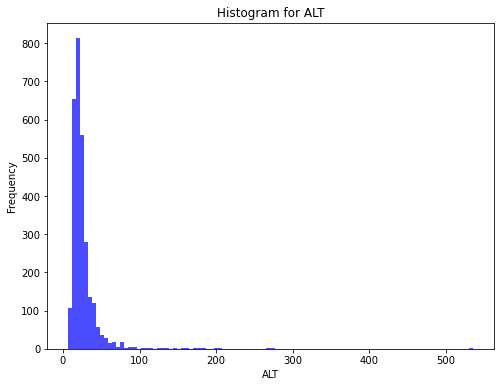

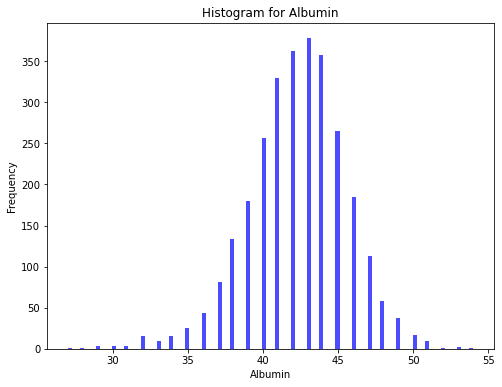

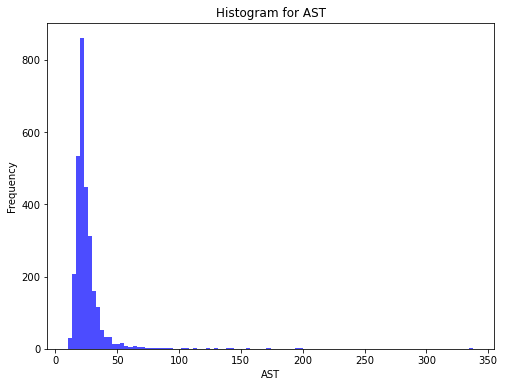

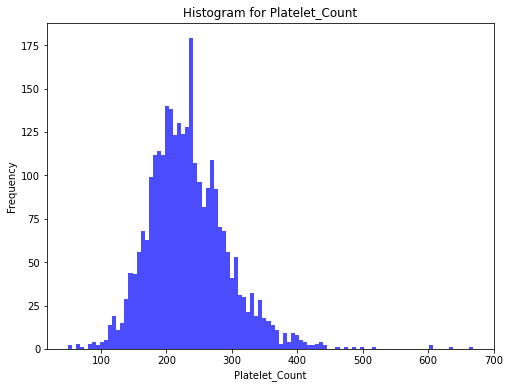

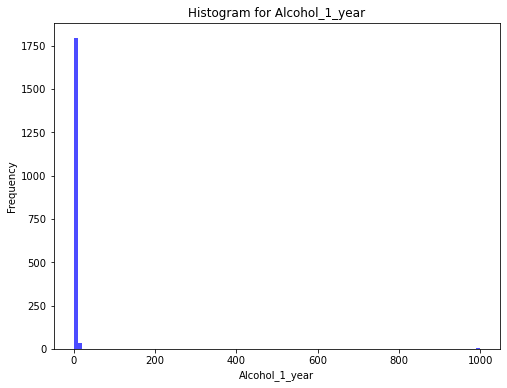

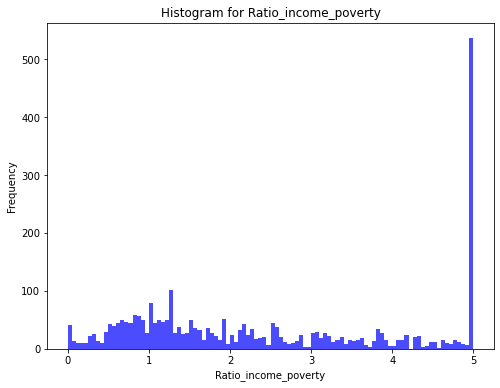

In [84]:
import matplotlib.pyplot as plt
continuous_columns = ['ALT', 'Albumin', 'AST', 'Platelet_Count', 'Alcohol_1_year', 'Ratio_income_poverty']

for column in continuous_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(nhanes1314[~nhanes1314[column].isna()][column], bins=100, color='blue', alpha=0.7)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [85]:
#Impute ALT, AST, PLT, PST with medians
#Impute income poverty ratio with PSU weighted means
#Impute Alcohol 1 year with weighted means
#Delete rows where Categorical features are missing

In [86]:
# Deleting records where categorical columns have missing values
categorical_columns = ['Education_level','Marital_status','liver_condition']

# Drop rows with missing values in specified categorical columns
nhanes1314 = nhanes1314.dropna(subset=categorical_columns)

In [87]:
#Imputing biochemistry variables
continuous_columns = ['ALT', 'Albumin', 'AST', 'Platelet_Count']

# Impute missing values with median
for column in continuous_columns:
    median_value = nhanes1314[column].median()
    nhanes1314[column].fillna(median_value, inplace=True)

In [88]:
#Imputing alcohol_1_year
alcohol_column = 'Alcohol_1_year'
weights_column = '2_year_interview_weight'  

# Calculate the weighted mean for Alcohol_1_year
weighted_mean = (nhanes1314[alcohol_column] * nhanes1314[weights_column]).sum() / nhanes1314[weights_column].sum()

# Impute missing values with the weighted mean for Alcohol_1_year
nhanes1314[alcohol_column].fillna(weighted_mean, inplace=True)

In [89]:
nhanes1314.columns

Index(['Respondent_sequence_number', 'Core_Antibody', 'Surface_Antigen',
       'Surface_Antibody', 'Vaccination', 'resp_2', 'Data_release_cycle',
       'Gender', 'Age', 'Race_Ethnicity', 'Veteran_Status', 'Country_of_birth',
       'Citizenship_status', 'Education_level', 'Marital_status',
       '2_year_interview_weight', '2_year_MEC_weight', 'Masked_variance_PSU',
       'Masked_variance_stratum', 'Ratio_income_poverty',
       'HH_Country_of_Birth', 'No_Insurance', 'Private_Insurance',
       'Governement_Insurance', 'Alcohol_1_year', 'Health_care_1_year',
       'liver_condition', 'Blood_Transfusion', 'Hepatitis_C', 'ALT', 'Albumin',
       'AST', 'Platelet_Count'],
      dtype='object')

In [90]:
nhanes1314['concat'] = nhanes1314['Masked_variance_stratum'].astype(str) + '_' + nhanes1314['Masked_variance_PSU'].astype(str)

In [91]:
nhanes1314['product'] = nhanes1314['Ratio_income_poverty']*nhanes1314['2_year_interview_weight']

In [92]:
nhanes1314_temp = nhanes1314.groupby('concat').sum()['product'].reset_index()

In [93]:
nhanes1314_temp_2 = nhanes1314.groupby('concat').sum()['2_year_interview_weight'].reset_index()

In [94]:
nhanes1314_temp_3  = pd.merge(nhanes1314_temp, nhanes1314_temp_2, on="concat", how = "left")

In [95]:
nhanes1314_temp_3['rip'] = nhanes1314_temp_3['product']/nhanes1314_temp_3['2_year_interview_weight']

In [96]:
nhanes1314_temp_4 = nhanes1314_temp_3[['concat','rip']]

In [97]:
nhanes1314 = pd.merge(nhanes1314,nhanes1314_temp_4, on='concat', how='left')

# Fill missing values in col_to_fill with mapping_value
nhanes1314['Ratio_income_poverty'] = nhanes1314['Ratio_income_poverty'].fillna(nhanes1314['rip'])

In [98]:
nhanes1314 = nhanes1314.drop(columns=['product','rip'])

In [99]:
# Replace "missing" with NaN
nhanes1314.replace('missing', np.nan, inplace=True)

# Drop rows with any missing values
nhanes1314 = nhanes1314.dropna()

In [102]:
nhanes1314 = nhanes1314.drop(columns=['HH_Country_of_Birth'])

In [107]:
nhanes1314[nhanes1314['Hepatitis_C']=='Yes'].count()

Respondent_sequence_number    28
Core_Antibody                 28
Surface_Antigen               28
Surface_Antibody              28
Vaccination                   28
resp_2                        28
Data_release_cycle            28
Gender                        28
Age                           28
Race_Ethnicity                28
Veteran_Status                28
Country_of_birth              28
Citizenship_status            28
Education_level               28
Marital_status                28
2_year_interview_weight       28
2_year_MEC_weight             28
Masked_variance_PSU           28
Masked_variance_stratum       28
Ratio_income_poverty          28
No_Insurance                  28
Private_Insurance             28
Governement_Insurance         28
Alcohol_1_year                28
Health_care_1_year            28
liver_condition               28
Blood_Transfusion             28
Hepatitis_C                   28
ALT                           28
Albumin                       28
AST       